<a href="https://colab.research.google.com/github/FLOWER-2024/TPTITANIC/blob/main/code%20_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================================================
# 0. PRÉPARATION DE L'ENVIRONNEMENT
# ===================================================

# Installer spaCy si ce n'est pas déjà fait
!pip install -U spacy

# Télécharger le modèle de langue français pour spaCy
!python -m spacy download fr_core_news_sm

print("Environnement prêt pour spaCy.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 97.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Environnement prêt pour spaCy.


In [ ]:
# ===================================================
# 1. IMPORTATIONS ET CONFIGURATION
# ===================================================
print("--- 1. Importation des bibliothèques ---")
# Importation des bibliothèques nécessaires pour l'analyse de texte, le machine learning, et la visualisation.
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
import spacy

# Modules pour la vectorisation (TF-IDF), l'encodage (One-Hot), et les pipelines de prétraitement/modélisation.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Modules pour la division des données, la validation croisée et l'optimisation des hyperparamètres.
from sklearn.model_selection import train_test_split, GridSearchCV
# Algorithmes de classification.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
# Métriques d'évaluation des modèles.
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
# Module pour gérer les déséquilibres de classes (SMOTE).
from imblearn.over_sampling import SMOTE
# Pipeline intégré pour imblearn.
from imblearn.pipeline import Pipeline as ImbPipeline

# Modules pour la visualisation des données.
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des graines aléatoires pour la reproductibilité des résultats.
SEED = 42
np.random.seed(SEED)
# Définition d'une palette de couleurs pour les visualisations.
colors_feminine = ['#FFB6C1', '#DB7093', '#C71585', '#BA55D3', '#9370DB', '#8A2BE2', '#4682B4']
sns.set_palette(sns.color_palette(colors_feminine))

# Téléchargement et chargement des modèles de langue nécessaires (NLTK et spaCy).
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    # Tentative de chargement du modèle français de spaCy.
    nlp = spacy.load('fr_core_news_sm')
    print("Modèle de langue 'fr_core_news_sm' chargé.")
except IOError:
    # Si le modèle n'est pas trouvé, afficher un message et télécharger le modèle.
    print("Modèle 'fr_core_news_sm' non trouvé. Téléchargement en cours...")
    # Téléchargement du modèle français de spaCy.
    !python -m spacy download fr_core_news_sm
    # Chargement du modèle après le téléchargement.
    nlp = spacy.load('fr_core_news_sm')
    print("Modèle de langue 'fr_core_news_sm' téléchargé et chargé.")

--- 1. Importation des bibliothèques ---
Modèle 'fr_core_news_sm' non trouvé. Téléchargement en cours...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 98.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Modèle de langue 'fr_core_news_sm' téléchargé et chargé.


In [ ]:
# ===================================================
# 2. FONCTIONS DE NETTOYAGE (AVEC LEMMATISATION) ET CHARGEMENT
# ===================================================
print("\n--- 2. Définition des fonctions et chargement des données ---")

def clean_text_spacy(text):
    """Nettoyage et lemmatisation du texte avec spaCy."""
    text = str(text).lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' date ', text)
    text = re.sub(r'\d+(?:[\.,]\d+)?\s*(?:mg|ml|cp|g|kg)', ' dosage ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text, disable=['parser', 'ner'])
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and len(token.lemma_) > 2]
    return ' '.join(lemmatized_tokens)

# Chargement du jeu de données
data = pd.read_csv('/content/data_defi3.csv', sep=';')
data = data.dropna(subset=['Avis.Pharmaceutique', 'PLT', 'Libellé.Prescription'])
data['PLT'] = pd.to_numeric(data['PLT'], errors='coerce').fillna(0).astype(int)
print("Données chargées avec succès.")


--- 2. Définition des fonctions et chargement des données ---
Données chargées avec succès.



--- 3. Préparation des données et analyse exploratoire ---


/tmp/ipython-input-1111102865.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_multi, order=y_multi.value_counts().index, palette=colors_feminine)
/tmp/ipython-input-1111102865.py:21: UserWarning: 
The palette list has fewer values (7) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=y_multi, order=y_multi.value_counts().index, palette=colors_feminine)


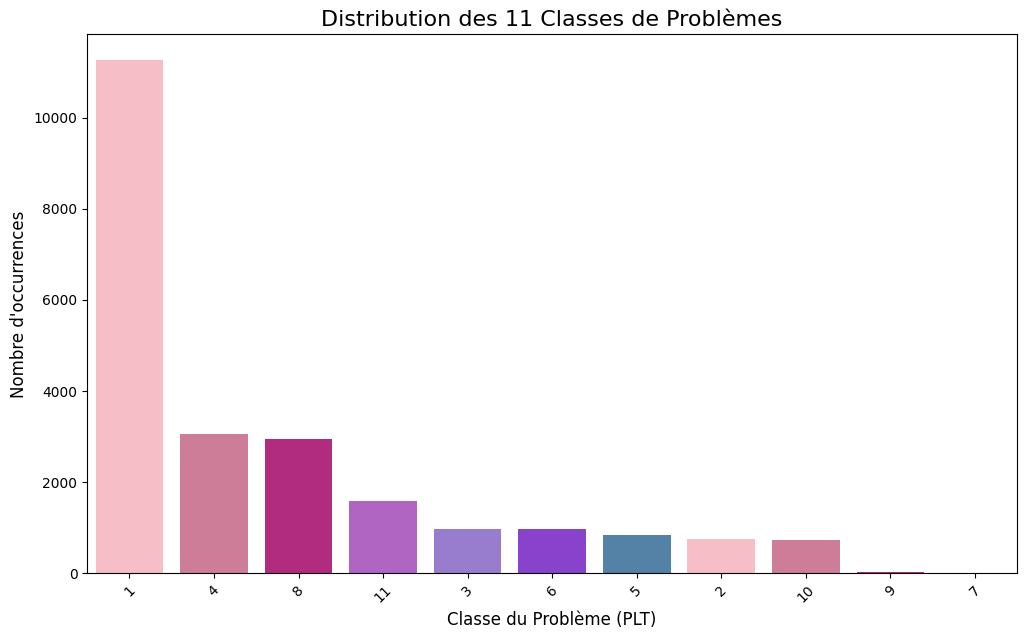

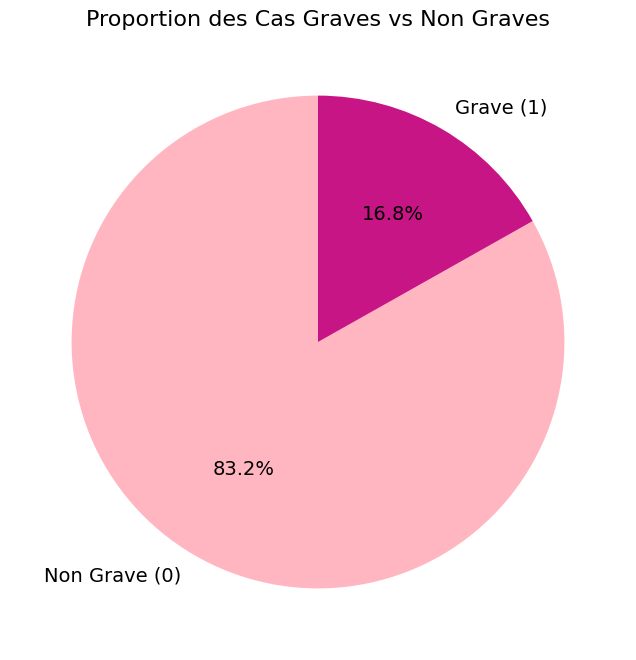

In [ ]:
# ===================================================
# 3. PRÉPARATION DES DONNÉES ET ANALYSE EXPLORATOIRE
# ===================================================
print("\n--- 3. Préparation des données et analyse exploratoire ---")

# Nettoyage et Feature Engineering
data['Avis_Cleaned'] = data['Avis.Pharmaceutique'].apply(clean_text_spacy) # Utilisation de la nouvelle fonction
data['Molecule_Cleaned'] = data['Libellé.Prescription'].astype(str).str.lower().str.strip()
avis_brut = data['Avis.Pharmaceutique'].str.lower()
data['contient_ci'] = avis_brut.str.contains('contre-indiqu|contre indication|CI', regex=True).astype(int)
data['contient_surdosage'] = avis_brut.str.contains('surdosage|diminuer la dose|réduire la posologie|dose trop|posologie élevée', regex=True).astype(int)
data['contient_interaction'] = avis_brut.str.contains('interaction|association déconseillée', regex=True).astype(int)

# Définition des cibles et features
y_binary = data['PLT'].isin([4, 5, 6.3, 6.4]).astype(int)
y_multi = data['PLT']
X = data[['Avis_Cleaned', 'Molecule_Cleaned', 'contient_ci', 'contient_surdosage', 'contient_interaction']]

# Graphique 1 : Distribution des classes
plt.figure(figsize=(12, 7))
sns.countplot(x=y_multi, order=y_multi.value_counts().index, palette=colors_feminine)
plt.title('Distribution des 11 Classes de Problèmes', fontsize=16)
plt.xlabel('Classe du Problème (PLT)', fontsize=12)
plt.ylabel('Nombre d\'occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Graphique 2 : Proportion des cas graves
plt.figure(figsize=(8, 8))
y_binary.value_counts().plot.pie(autopct='%1.1f%%', colors=['#FFB6C1', '#C71585'], labels=['Non Grave (0)', 'Grave (1)'], startangle=90, textprops={'fontsize': 14})
plt.title('Proportion des Cas Graves vs Non Graves', fontsize=16)
plt.ylabel('')
plt.show()

In [ ]:
# ===================================================
# 4. DIVISION TRAIN/TEST ET PRÉPROCESSEUR
# ===================================================

# Division Train/Test
X_train, X_test, y_train_bin, y_test_bin, y_train_multi, y_test_multi = train_test_split(
    X, y_binary, y_multi, test_size=0.2, random_state=SEED, stratify=y_multi
)

# Pipeline de prétraitement
french_stopwords_custom = list(nlp.Defaults.stop_words) + ['patient', 'traitement', 'prescription', 'jour', 'matin', 'soir']
preprocessor = ColumnTransformer(
    transformers=[
        ('txt', TfidfVectorizer(stop_words=french_stopwords_custom, ngram_range=(1, 3), max_features=5000, min_df=3, sublinear_tf=True), 'Avis_Cleaned'),
        ('mol', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['Molecule_Cleaned'])
    ],
    remainder='passthrough'
)
print("Données divisées et préprocesseur créé.")

Données divisées et préprocesseur créé.


In [ ]:
# ===================================================
# 5. TÂCHE 1 (BINAIRE) : RECHERCHE D'HYPERPARAMÈTRES ET ENTRAÎNEMENT
# ===================================================
print("\n--- Tâche 1 (Binaire) : Entraînement et Optimisation ---")

# Modèles et Pipeline complet
clf1 = LogisticRegression(max_iter=2000, solver='liblinear', random_state=SEED)
clf2 = RandomForestClassifier(random_state=SEED, n_jobs=-1)
ratio = float(np.sum(y_train_bin == 0)) / np.sum(y_train_bin == 1)
clf3 = XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss', random_state=SEED, n_jobs=-1)
voting_clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')

binary_pipeline_base = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', voting_clf)
])

# GridSearchCV pour optimiser les hyperparamètres
param_grid = {
    'classifier__lr__C': [1.0, 10],
    'classifier__rf__n_estimators': [100, 200],
    'classifier__xgb__n_estimators': [100, 200]
}
grid_search = GridSearchCV(binary_pipeline_base, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
print("Lancement de GridSearchCV... (peut prendre plusieurs minutes)")
grid_search.fit(X_train, y_train_bin)

# Le meilleur pipeline optimisé
binary_pipeline = grid_search.best_estimator_

print(f"\nMeilleurs paramètres trouvés : {grid_search.best_params_}")


--- Tâche 1 (Binaire) : Entraînement et Optimisation ---
Lancement de GridSearchCV... (peut prendre plusieurs minutes)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:48:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Meilleurs paramètres trouvés : {'classifier__lr__C': 10, 'classifier__rf__n_estimators': 100, 'classifier__xgb__n_estimators': 200}


In [ ]:
# ===================================================
# 6. TÂCHE 1 (BINAIRE) : ÉVALUATION ET CHOIX DU SEUIL
# ===================================================
print("\n--- Tâche 1 (Binaire) : Évaluation et choix du seuil ---")

def evaluate_threshold(name, y_true, y_probas, threshold):
    print(f"\n--- Résultats pour la stratégie : '{name}' (Seuil = {threshold:.4f}) ---")
    y_pred = (y_probas >= threshold).astype(int)
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print(f"Matrice de confusion :\n{cm}")
    print(f"Cas graves manqués (FN) : {cm[1, 0]} sur {cm[1, 0] + cm[1, 1]}")
    return cm

y_probas = binary_pipeline.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_probas)

# Stratégie 1 : F1-Score
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_idx_f1 = np.nanargmax(f1_scores)
best_threshold_f1 = thresholds[best_idx_f1]
cm_f1 = evaluate_threshold("F1-Score Optimal", y_test_bin, y_probas, best_threshold_f1)

# Stratégie 2 : Rappel
min_precision = 0.70
valid_indices = np.where(precisions[:-1] >= min_precision)[0]
if len(valid_indices) > 0:
    best_idx_recall = valid_indices[np.argmax(recalls[valid_indices])]
    best_threshold_recall = thresholds[valid_indices[np.argmax(recalls[valid_indices])]]
    cm_recall = evaluate_threshold(f"Rappel Optimal (Précision >= {min_precision:.0%})", y_test_bin, y_probas, best_threshold_recall)
else:
    best_threshold_recall = best_threshold_f1
    cm_recall = cm_f1
    print("Aucun seuil trouvé pour une précision >= 70%. Utilisation du seuil F1 optimal.")


# Décision finale
final_threshold = best_threshold_recall
y_pred_bin_opt = (y_probas >= final_threshold).astype(int)
print(f"\n==> Seuil final retenu pour la sécurité : {final_threshold:.4f}")


--- Tâche 1 (Binaire) : Évaluation et choix du seuil ---

--- Résultats pour la stratégie : 'F1-Score Optimal' (Seuil = 0.5654) ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3850
           1       0.81      0.78      0.79       779

    accuracy                           0.93      4629
   macro avg       0.88      0.87      0.88      4629
weighted avg       0.93      0.93      0.93      4629

Matrice de confusion :
[[3703  147]
 [ 170  609]]
Cas graves manqués (FN) : 170 sur 779

--- Résultats pour la stratégie : 'Rappel Optimal (Précision >= 70%)' (Seuil = 0.4188) ---
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3850
           1       0.70      0.85      0.77       779

    accuracy                           0.91      4629
   macro avg       0.83      0.89      0.86      4629
weighted avg       0.92      0.91      0.92      4629

Matrice de confusion :
[[3566  28


--- Tâche 2 (Multiclasse) : Entraînement et Évaluation ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:54:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Résultats Tâche 2 (XGBoost) ---
              precision    recall  f1-score   support

           1       0.80      0.92      0.86      2253
           2       0.84      0.67      0.75       151
           3       0.56      0.29      0.38       194
           4       0.78      0.72      0.75       613
           5       0.61      0.52      0.56       166
           6       0.80      0.81      0.81       193
           7       0.00      0.00      0.00         2
           8       0.77      0.71      0.74       589
           9       0.75      0.75      0.75         4
          10       0.70      0.64      0.66       148
          11       0.67      0.49      0.56       316

    accuracy                           0.78      4629
   macro avg       0.66      0.59      0.62      4629
weighted avg       0.77      0.78      0.77      4629



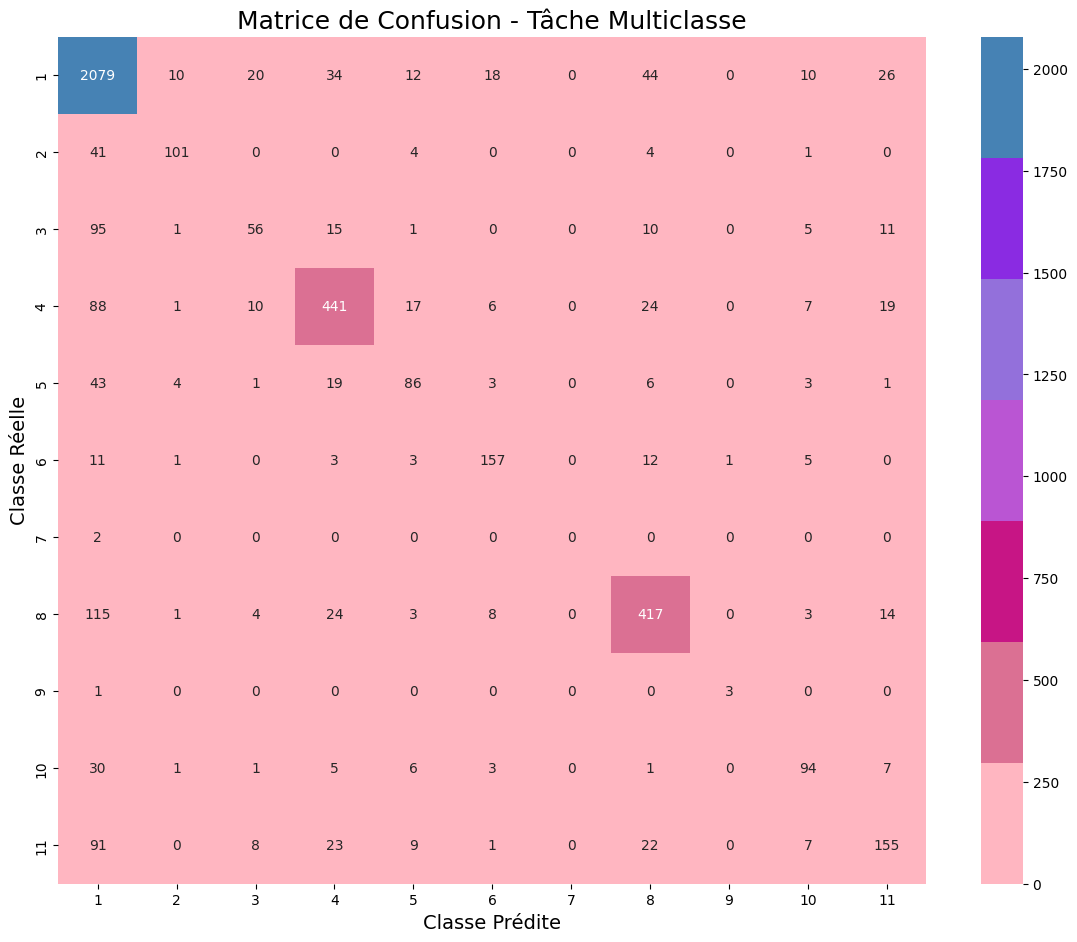

In [ ]:
# ===================================================
# 8. TÂCHE 2 (MULTICLASSE) : MODÈLE, ENTRAÎNEMENT ET ÉVALUATION
# ===================================================
print("\n--- Tâche 2 (Multiclasse) : Entraînement et Évaluation ---")

xgb_multi = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_multi)), n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, n_jobs=-1)
multi_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', xgb_multi)])

unique_classes = sorted(data['PLT'].unique())
class_map = {cls: i for i, cls in enumerate(unique_classes)}
inv_class_map = {i: cls for cls, i in class_map.items()}
y_train_multi_mapped = y_train_multi.map(class_map)

multi_pipeline.fit(X_train, y_train_multi_mapped)
y_pred_multi_mapped = multi_pipeline.predict(X_test)
y_pred_multi = pd.Series(y_pred_multi_mapped).map(inv_class_map)

print("\n--- Résultats Tâche 2 (XGBoost) ---")
print(classification_report(y_test_multi, y_pred_multi, zero_division=0))

# Graphique 5 : Matrice de Confusion Multiclasse
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
class_labels = sorted(y_multi.unique())
plt.figure(figsize=(14, 11))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap=sns.color_palette(colors_feminine, as_cmap=True), xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion - Tâche Multiclasse', fontsize=18)
plt.xlabel('Classe Prédite', fontsize=14)
plt.ylabel('Classe Réelle', fontsize=14)
plt.show()